In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse


from scipy.stats import jarque_bera
from scipy.stats import normaltest




import warnings
warnings.filterwarnings('ignore')

# Step 1: Load Data Set

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

## Purpose: 
To build a housing price model that will focus on target variable, Y, 'saleprice'.  

In part I: We will review explanatory variables, identify those that need 'dummy' treatment for more specific analysis to select relevant explanatory variables. Then we we will explore how selected feature variables will explain 'saleprice' in the following regression models. 

In part II: We will split our data into train and test sets where 20% of the data resides in the test set.
Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. 

We will use k-fold cross-validation to select the best hyperparameters if my models include one!
Then we will evaluate our best model on the test set.

Because house prices may be affected by many factors-- like economic activity and the interest rates at the time they are sold. So, we will try to find some useful factors that are not included in the dataset, like unemployment rate. Then we will integrate this third factor into our model and assess the prediction performance of our model. Finally, we will discuss the implications of adding these external variables into our model.

## Step 2, Phase 1: Data Cleaning

## Observation:
Run the data set to see both numerical and categorical data. Then, look for year sold column "yrsold" to identify the years needed for future analysis of other economic situational developments that may influence housing prices. 

In [3]:
house_df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [4]:
#Look for most popular year in which listed.
import statistics

house_df['yrsold'].mean()

2007.8157534246575

In [5]:
house_df['yrsold'].mode()

0    2009
dtype: int64

#### Analysis: 
We see that the year when most houses sold was in 2009, according to our mode function. So we will consider this when selecting external variable to explain our target in our model: 'saleprice'. 
In Iowa, we can use the Iowa Workforce Development office data to gather employment statistics between 2001 and 2010. In 2008, we saw the mortgage crisis, which underpinned the 2008 Financial crisis. Housing prices were lower during the crisis.  https://www.iowaworkforcedevelopment.gov/current-employment-statistics

In [6]:
non_numeric_columns = house_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [7]:
house_df_dummified = pd.get_dummies(house_df, drop_first=True, columns=['salecondition'], prefix='salecondition')

In [8]:
house_df_dummified = pd.get_dummies(house_df_dummified, drop_first=True, columns=['mszoning'], prefix='mszoning')

In [9]:
house_df_dummified.columns

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive', 'woo

### Missing Values

In [10]:
total_missing = house_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_df.isnull().sum()/house_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


#### Observations: 
The columns with missing values do not represent the features we will be exploring, so no need to address missing values.
 

## Step 2, Phase 2: Exploratory Data Analysis

In [11]:
house_df_dummified.describe

<bound method NDFrame.describe of         id  mssubclass  lotfrontage  lotarea street alley lotshape  \
0        1          60         65.0     8450   Pave  None      Reg   
1        2          20         80.0     9600   Pave  None      Reg   
2        3          60         68.0    11250   Pave  None      IR1   
3        4          70         60.0     9550   Pave  None      IR1   
4        5          60         84.0    14260   Pave  None      IR1   
...    ...         ...          ...      ...    ...   ...      ...   
1455  1456          60         62.0     7917   Pave  None      Reg   
1456  1457          20         85.0    13175   Pave  None      Reg   
1457  1458          70         66.0     9042   Pave  None      Reg   
1458  1459          20         68.0     9717   Pave  None      Reg   
1459  1460          20         75.0     9937   Pave  None      Reg   

     landcontour utilities lotconfig  ... saleprice salecondition_AdjLand  \
0            Lvl    AllPub    Inside  ...    208

In [12]:
import statistics
statistics.mode(house_df['salecondition'])

'Normal'

In [13]:
house_df_dummified.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,saleprice,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.021917,-0.034852,-0.009018,0.004865,0.015881,-0.020738,-0.012020,0.032453,0.031034,-0.032379
mssubclass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.084284,0.016241,0.030002,0.000983,0.024359,-0.051068,0.171336,0.058288,-0.343353,0.277750
lotfrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.351799,-0.037030,-0.019817,0.016684,-0.076258,0.126571,-0.097092,-0.047950,0.346736,-0.324638
lotarea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.263843,-0.013208,0.008966,-0.010781,0.005711,0.022635,-0.083895,-0.033092,0.204065,-0.173709
overallqual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.790982,-0.041677,-0.044950,-0.025515,-0.143282,0.323295,0.171854,-0.064666,0.126972,-0.195515
overallcond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.077856,-0.038888,-0.033444,-0.023873,0.161642,-0.151659,-0.105671,-0.001215,-0.069669,0.158205
yearbuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.522897,-0.045601,-0.010104,-0.035785,-0.158427,0.343895,0.237645,-0.089183,0.268064,-0.388683
yearremodadd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.507101,-0.040294,-0.020727,-0.048056,-0.120577,0.322837,0.208816,-0.065939,0.074221,-0.161815
masvnrarea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.477493,-0.011959,-0.010116,-0.009915,-0.084801,0.167483,0.043313,-0.026752,0.091688,-0.110336
bsmtfinsf1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.386420,-0.014874,0.021369,0.000765,-0.019560,0.044912,-0.054799,-0.030218,0.206887,-0.187268


#### Analysis: 
The most highly correlated among categorical variables are in the 'moderate' correlation groupiong and are as follows:
a) 'firstflrsf' with 'lotfrontage' of .457
b) 'lotfrontage' with 'lotarea' of .426
c) 'mszoning_FV' with 'mszoning_RL' of -.417


The most common type of 'salecondition' is 'Normal'.
Furthermore, we need to address our dummy variables that will make up our features in our model. These will be 'mszoning' and 'salecondition'.

## Step 2, Phase 3: Feature Engineering

In [14]:
columns_to_fit = [x for x in house_df_dummified.columns if 'mszoning' in x or 'salecondition' in x] 

In [15]:
# Y is the target variable, in other words what are trying to predict.
Y = house_df_dummified['saleprice']

# X is the feature set we are using to predict the house prices
X = house_df_dummified[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf'] + columns_to_fit]

### Visualization of Features

#### Visualization 1

Text(0.5, 1.0, 'horizontal bar chart 1: Sale Prices by Sale Condition')

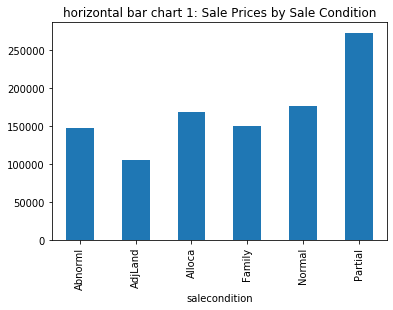

In [16]:
house_df.groupby("salecondition")["saleprice"].mean().plot.bar()
plt.title("horizontal bar chart 1: Sale Prices by Sale Condition")

#### Visualization 2

Text(0.5, 1.0, 'horizontal bar chart 2: Sale Prices by MS Zoning')

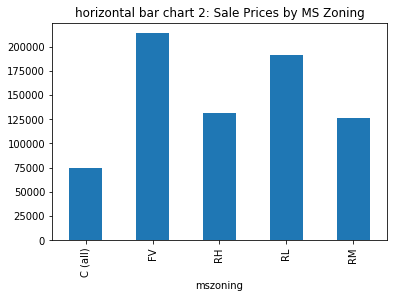

In [17]:
house_df.groupby("mszoning")["saleprice"].mean().plot.bar()
plt.title("horizontal bar chart 2: Sale Prices by MS Zoning")

#### Visualization 3 -- Change

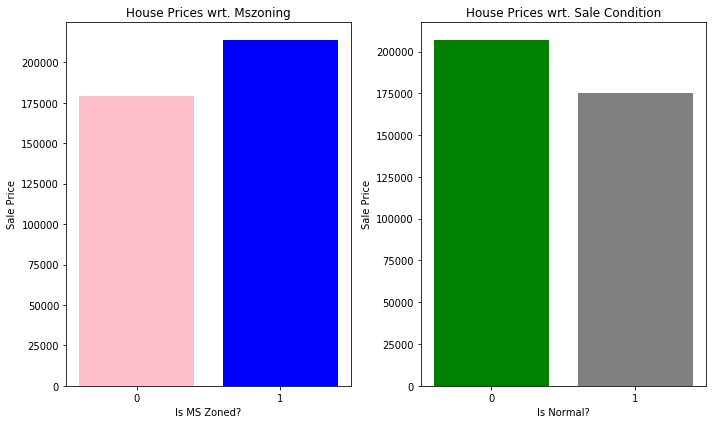

In [18]:
plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.bar(house_df_dummified.groupby("mszoning_FV")["saleprice"].mean().index, house_df_dummified.groupby("mszoning_FV")["saleprice"].mean(),
       color=("pink","blue"))
plt.title("House Prices wrt. Mszoning")
plt.ylabel("Sale Price")
plt.xlabel("Is MS Zoned?")
plt.xticks([0,1])

plt.subplot(1,2,2)
plt.bar(house_df_dummified.groupby("salecondition_Normal")["saleprice"].mean().index, house_df_dummified.groupby("salecondition_Normal")["saleprice"].mean(),
       color=("green","grey"))
plt.title("House Prices wrt. Sale Condition")
plt.ylabel("Sale Price")
plt.xlabel("Is Normal?")
plt.xticks([0,1])

plt.tight_layout()
plt.show()

#plt.title("horizontal bar chart 3: Sale Prices by Sale Condition")

# bar chart of house conditions
#plt.figure(figsize=(15,5))
#plt.barh(house_df.groupby("salecondition")["salecondition"].count(), 
 #       color=["red","green","blue","grey","pink"])
#plt.title("horizontal bar chart of sale prices")

#plt.show()


#### Analysis: 
The figure on the right shows that houses that are "MS_Zoned" are coded as "1" for "yes" to dummy variable. These houses have higher sale prices. The figure on the left shows that houses that are in "Normal" condition are coded as "1" for "yes" to dummy variable. Normal houses do not have the highest sale prices. The following types of sales conditions may have higher prices: 1) 'salecondition_AdjLand', 2) 'salecondition_Alloca', 3) 'salecondition_Family', and 4) 'salecondition_Partial'. Visualization 4 below will show each house 'saleprice' versus every dummy variable created, which added 43 columns.

#### Visualization 4: 

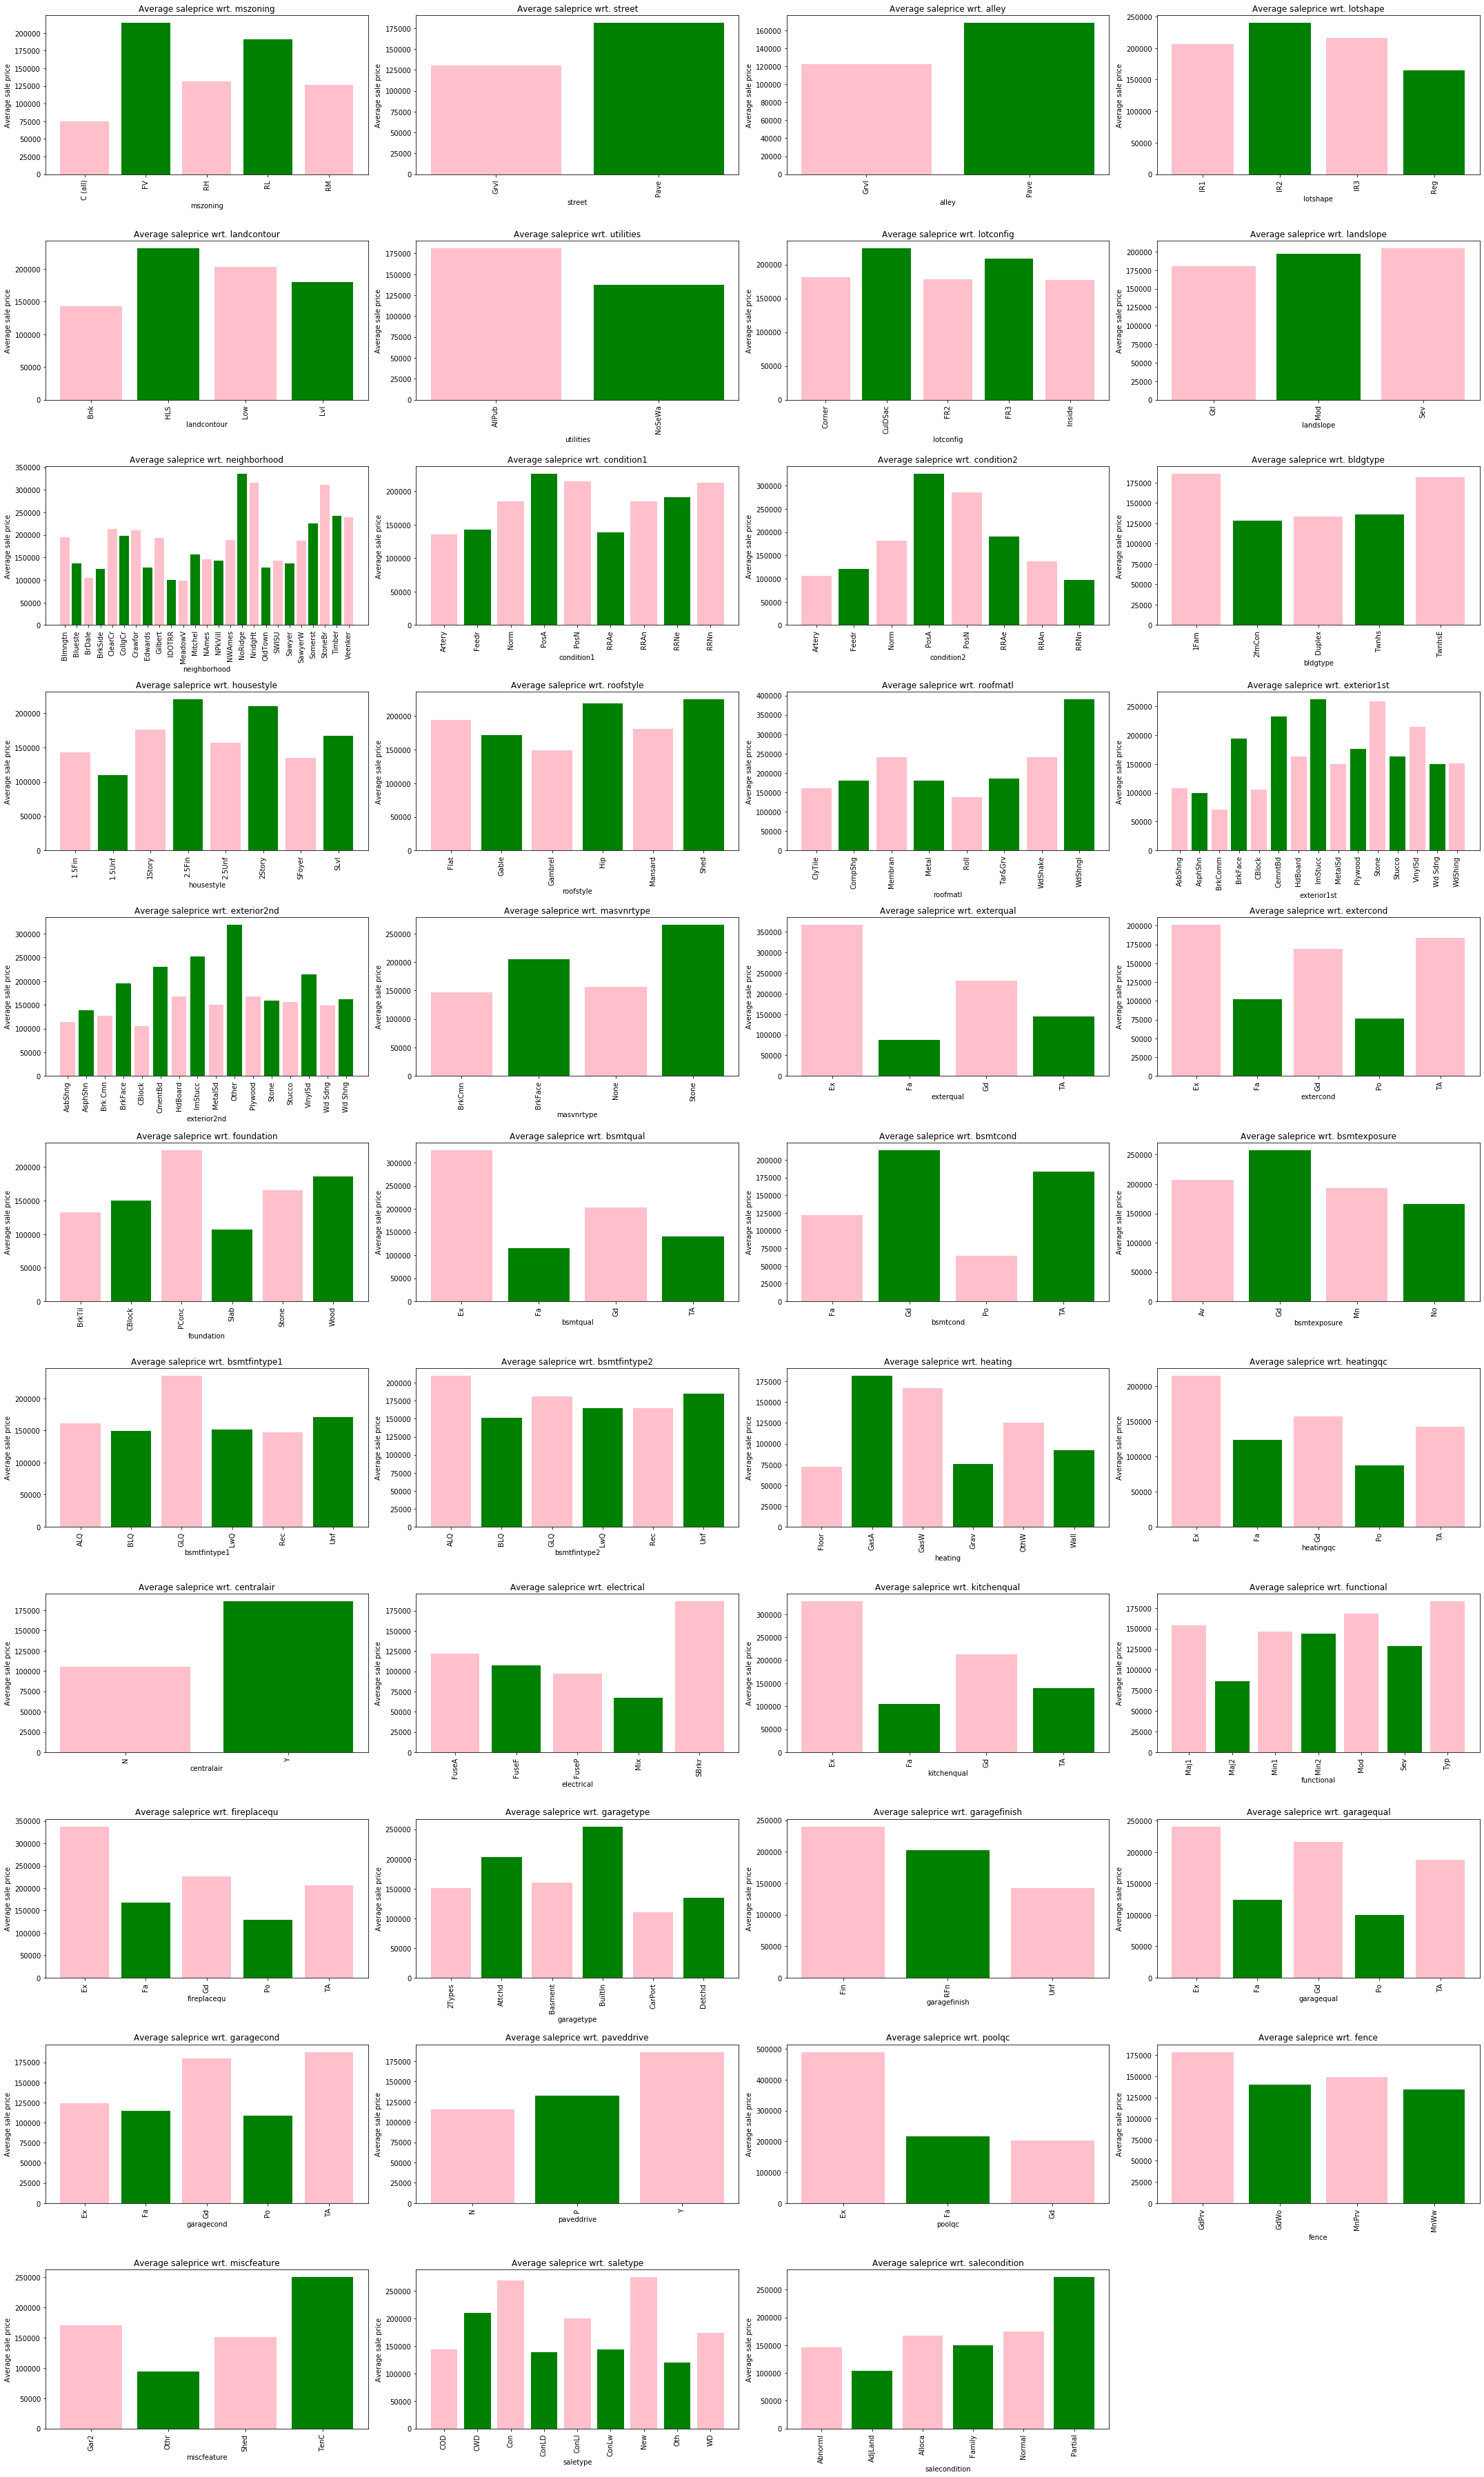

In [19]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_df.groupby(column)["saleprice"].mean().index, house_df.groupby(column)["saleprice"].mean(),
           color=("pink","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

### OLS Model

In [20]:
# Y is the target variable
Y = house_df['saleprice']
# X is the feature set which includes
# dummified variables
X = house_df_dummified[columns_to_fit]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-59476.95179673  21815.66507042   3488.48680105  21559.90029216
 110544.70413423  99940.51735703  53013.47017305  99879.47842064
  41578.01642803]

Intercept: 
 63722.4733760946


# Part 2 
## Step 3: Split Data Into Train and Test Sets 



Train them in the training set.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [22]:
X_train.head()

,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM
151,0,0,0,1,0,0,0,1,0
262,0,0,0,0,1,0,0,1,0
1037,0,0,0,1,0,0,0,1,0
1183,0,0,0,1,0,0,0,1,0
933,0,0,0,1,0,0,0,1,0


In [23]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              saleprice   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              904.2
Date:                Fri, 01 May 2020   Prob (F-statistic):                        0.00
Time:                        12:15:41   Log-Likelihood:                         -14679.
No. Observations:                1168   AIC:                                  2.938e+04
Df Residuals:                    1159   BIC:                                  2.942e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

#### Analysis: 
In our OLS model, our F-statisic is 2085 and the p-value is close to 0. Also the R-squared value is .962. This means that 96 percent of our data set is explained by our OLS model. At the same time, a such a very high R-square may mean that our OLS model may be overfitting the data. So we will see if our model performs significantly worse on the test set compared to the training set before moving on to Step 4. If so, then we should suspect overfitting. 

In [24]:
# Y is the target variable
Y = house_df['saleprice']

columns_to_fit = [x for x in house_df_dummified.columns if 'mszoning' in x or 'salecondition' in x] 


X = house_df_dummified[columns_to_fit]

X = pd.concat([X**i for i in range(1,21)], axis=1)

# X is the feature set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 1168
The number of observations in test set is 292
R-squared of the model in the training set is: 0.2184354405869906
-----Test set statistics-----
R-squared of the model in the test set is: 0.16297910333226595
Mean absolute error of the prediction is: 51992.434743854385
Mean squared error of the prediction is: 5619510608.227857
Root mean squared error of the prediction is: 74963.39512207179
Mean absolute percentage error of the prediction is: 30.92300741911978


#### Analysis: 
The R-squared value of training set means that 21.8 percent of the data is explainable. However, only 16.3 percent of the data is explainable, according to the test set.  There's a 5 percent difference between the linear regression model's training and test sets' R-squared values. We will review the R-squared values of the next three models to compare. 

# Step 4: BuildRegression Models~ Lasso, Ridge, or ElasticNet 

### Note: 
We will need to use "k-fold cross-validation" to choose the best hyperparameter values from the other three models when running the Lasso, Ridge, and ElasticNet models training and test sets. After running, we will review their "R-squared" values on test set data.   

### Lasso Model

In [25]:
from sklearn.linear_model import Lasso

# lassoregr = Lasso(alpha=10**20.5) 
lassoregr = Lasso(alpha=0.0005) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.22718848280194526
-----Test set statistics-----
R-squared of the model on the test set is: 0.15578187579563485
Mean absolute error of the prediction is: 52146.11455504071
Mean squared error of the prediction is: 5667830664.098556
Root mean squared error of the prediction is: 75284.99627481266
Mean absolute percentage error of the prediction is: 31.107299576741525


#### Analysis: 
Our Lasso model's R-squared term is .775 for the Lasso model training set. So 77 percent of our data can be explained by the Lasso model. However, the test set is higher-- showing 78 percent--compared to the training set as well as the LRM test set's R-squared (16.3 percent). There's less than .1 percent difference between the Lasso model's training and test sets. We should consider this metric when comparing against the other models. 

### Ridge Model

In [26]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=100) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.22371255407799306
-----Test set statistics-----
R-squared of the model on the test set is: 0.15093275025972852
Mean absolute error of the prediction is: 52545.240565200605
Mean squared error of the prediction is: 5700386257.98891
Root mean squared error of the prediction is: 75500.90236539501
Mean absolute percentage error of the prediction is: 31.945460840713896


#### Analysis: 
Our Ridge model's R-squared term is .769. So 76.9 percent of our training set data can be explained by the Ridge model. Our test set data is 77.7 percent, which is significantly higher than our Lasso model's test set data R-square value. There's less than a .1 percent difference between the Ridge model's training and test sets. Note: Ridge regression is supposed to shrink parameter estimates. 

### ElasticNet Model

In [27]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=10**21, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0016183407463286061
Mean absolute error of the prediction is: 58023.64411709514
Mean squared error of the prediction is: 6724569139.943377
Root mean squared error of the prediction is: 82003.47029207592
Mean absolute percentage error of the prediction is: 36.65964810134902


#### Analysis: 
Our R-squared term for the training set is .0 in our ElasticNet model. R-squared value for test set data is negative. Hence, our ElasticNet model is weaker than a straight horizontal line and does poorly in explaining out target variable: house sales price, or 'saleprice'. 

Overall, Lasso produced the best model results in that the model covers the largest portion: 77.5 percent (R-squared value) and represents the smallest difference between test and training sets' data R-squared value. 

# Step 5: Evaluate your best model on the test set.

#### Analysis:
We see that ElasticNet model performed the worst on our test set. Our Lasso model performed the best on its test set.

Note: to select the best model, we may also compare each model's Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC). Both take into consideration the sum of the squared errors (SSE), the sample size, and the number of parameters.

# Step 6: Integrate External Variable & Discuss Implications 

#### Note: We will integrate an external variable, like the employment rate. The implications of including signifies that we believe employment rate will help explain our target variable, the house sale prices, or 'saleprice'. 

In [39]:
!open /Users/mehrunisaqayyum/Downloads/SeriesReport-20200501133702_7cf3dd.xlsx

In [40]:
pd.read_excel?

In [52]:
#Import employment stats file

import pandas as pd
employ_file = '/Users/mehrunisaqayyum/Downloads/unemployment_ble.xlsx'
employ_df = pd.read_excel(employ_file, header=1)
employ_df

,Year,Period,labor force participation rate,employment-population ratio,labor force,employment,unemployment,unemployment rate
0,2005,Jan,71.1,67.9,1614081,1541929,72152,4.5
1,2005,Feb,71.3,68.1,1617648,1546143,71505,4.4
2,2005,Mar,71.4,68.3,1620980,1550131,70849,4.4
3,2005,Apr,71.5,68.4,1623973,1553802,70171,4.3
4,2005,May,71.6,68.5,1626722,1557231,69491,4.3
...,...,...,...,...,...,...,...,...
91,2012,Aug,69.1,65.6,1651397,1568392,83005,5.0
92,2012,Sep,69.1,65.6,1652163,1569562,82601,5.0
93,2012,Oct,69.0,65.6,1653077,1570981,82096,5.0
94,2012,Nov,69.1,65.6,1654247,1572489,81758,4.9


In [53]:
#checking to see if categorical months converted to numeric months
house_df.mosold.value_counts()

6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: mosold, dtype: int64

In [56]:
def month_to_number(stringa):
    if stringa == 'Jan':
        return 1
    elif stringa == 'Feb':
        return 2
    elif stringa == 'Mar':
        return 3
    elif stringa == 'Apr':
        return 4
    elif stringa == 'May':
        return 5
    elif stringa == 'Jun':
        return 6
    elif stringa == 'Jul':
        return 7
    elif stringa == 'Aug':
        return 8
    elif stringa == 'Sep':
        return 9
    elif stringa == 'Oct':
        return 10
    elif stringa == 'Nov':
        return 11
    elif stringa == 'Dec':
        return 12
    else:
        return 'Damn broken dataset'
    
employ_df['month_as_number'] = employ_df.Period.apply(month_to_number)

In [32]:
employ_df.columns

Index(['Local Area Unemployment Statistics', 'Unnamed: 1', 'Unnamed: 2',
       'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12'],
      dtype='object')

In [62]:
#join'year' from employ_df on 'yrsold' from house_df_dummified
house_df_dummified_unempl = pd.merge(house_df_dummified, employ_df[['Year', 'month_as_number', 'unemployment rate']], left_on=['yrsold', 'mosold'], right_on=['Year', 'month_as_number'])

In [33]:
employ_df.index

RangeIndex(start=0, stop=21, step=1)

In [63]:
house_df_dummified_unempl.columns

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'street', 'alley',
       'lotshape', 'landcontour', 'utilities', 'lotconfig', 'landslope',
       'neighborhood', 'condition1', 'condition2', 'bldgtype', 'housestyle',
       'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd', 'roofstyle',
       'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype', 'masvnrarea',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1', 'bsmtfintype2',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating', 'heatingqc',
       'centralair', 'electrical', 'firstflrsf', 'secondflrsf', 'lowqualfinsf',
       'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath',
       'bedroomabvgr', 'kitchenabvgr', 'kitchenqual', 'totrmsabvgrd',
       'functional', 'fireplaces', 'fireplacequ', 'garagetype', 'garageyrblt',
       'garagefinish', 'garagecars', 'garagearea', 'garagequal', 'garagecond',
       'paveddrive', 'woo

In [67]:
# Y is the target variable
Y = house_df_dummified_unempl['saleprice']



# X is the feature set which includes
# dummified variables
#ADD in rate to X = house_df_dummified_unempl[columns_to_fit + [house_df_dummified_unempl['unemployment rate']]
X = house_df_dummified_unempl[['overallqual', 'grlivarea', 'garagecars', 'garagearea','totalbsmtsf','unemployment rate'] + columns_to_fit]


# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 2.21769606e+04  4.68981479e+01  1.31961318e+04  1.17292130e+01
  2.68826459e+01  2.53450030e+02  1.14449199e+04  8.52772790e+03
 -1.06627377e+04  9.76653278e+03  3.35232290e+04  1.73549844e+04
  1.23345314e+04  2.56001113e+04  6.40418110e+03]

Intercept: 
 -116792.62382900083


Our OLS model:
    salesprice = -11,6792.62 + 22176.96'overallqual' + 46.9'grlivarea' + 13,196.13'garagecars' + 11.7'totalbsmtsf' + 26.88'unemployment rate' + 253.45'salecondition_AdjLand' +  11,444.92'salecondition_Alloca' + 8,527.73'salecondition_Family' -10,662.74'salecondition_Normal'   +  9,766.53'salecondition_Partial' + 3,3523.23'mszoning_FV'   +17,354.98'mszoning_RH'  + 12,334.53'mszoning_RL' +6,404.18'mszoning_RM

In [69]:
# We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              saleprice   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              904.2
Date:                Fri, 01 May 2020   Prob (F-statistic):                        0.00
Time:                        16:01:41   Log-Likelihood:                         -14679.
No. Observations:                1168   AIC:                                  2.938e+04
Df Residuals:                    1159   BIC:                                  2.942e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Note: We will use the Lasso model and integrate our new unemployment variable 'unemployment rate'. 
Then we will assess the prediction performance of our model. Finally, we will discuss the implications of adding this external variable into our model.

In [68]:
from sklearn.linear_model import Lasso

# lassoregr = Lasso(alpha=10**20.5) 
lassoregr = Lasso(alpha=0.0005) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.22718848280194526
-----Test set statistics-----
R-squared of the model on the test set is: 0.15578187579563485
Mean absolute error of the prediction is: 52146.11455504071
Mean squared error of the prediction is: 5667830664.098556
Root mean squared error of the prediction is: 75284.99627481266
Mean absolute percentage error of the prediction is: 31.107299576741525


### Analysis: 

We integrated the unemployment rate to help explain Iowa's house sale prices in each year. Based on our OLS model, we see that our model fits 87.5 percent of the training data. Compared to our Lasso model's training and test sets: we see that the OLS model may have 'overfit'. We say this because 22.71 percent of the training set fit th model. After running the test set, the R-squared dropped further to 15.58 percent of fitting the data.

When we compare our Lasso model that added the new explanatory variable (unemployment rate) to the Lasso model without the unemployment rate (from Module 18.7) we see that the performance power decreased. The previous Lasso produced the best model results in that the model had covered the largest portion: 77.5 percent (R-squared value) and represented the smallest difference between test and training sets' data R-squared value. 

In this new Lasso model with unemployment rate, the R-squared significantly dropped to 22.71 percent. This implies that other explanatory variables may be needed to explain housing prices since there could be some assumptions behind the interaction. Specifically, we assume that when employment rates are high, purchasing homes increase, and thereby increase the bigging price for houses. However, we do not necessarily see that in our unemployment rate coefficient: 26.88. It is the second lowest coefficient in our model--or on lower magnitude of impact on the spectrum of included variables. 